# Designing Agentic system Combining RAG and Text-to-SQL in a Single Query Interface

- Helps convert natural language text into syntactically correct SQL statement based on defined DB schema and subsequently fetches Information post sql-query execution.
- Can fetch knowledge from RAG with Airbnb listings knowledge base stored in ChromaDB.
- Router Agent efficciently routes to text-to-sql engine or RAG knowledge base based on user input.


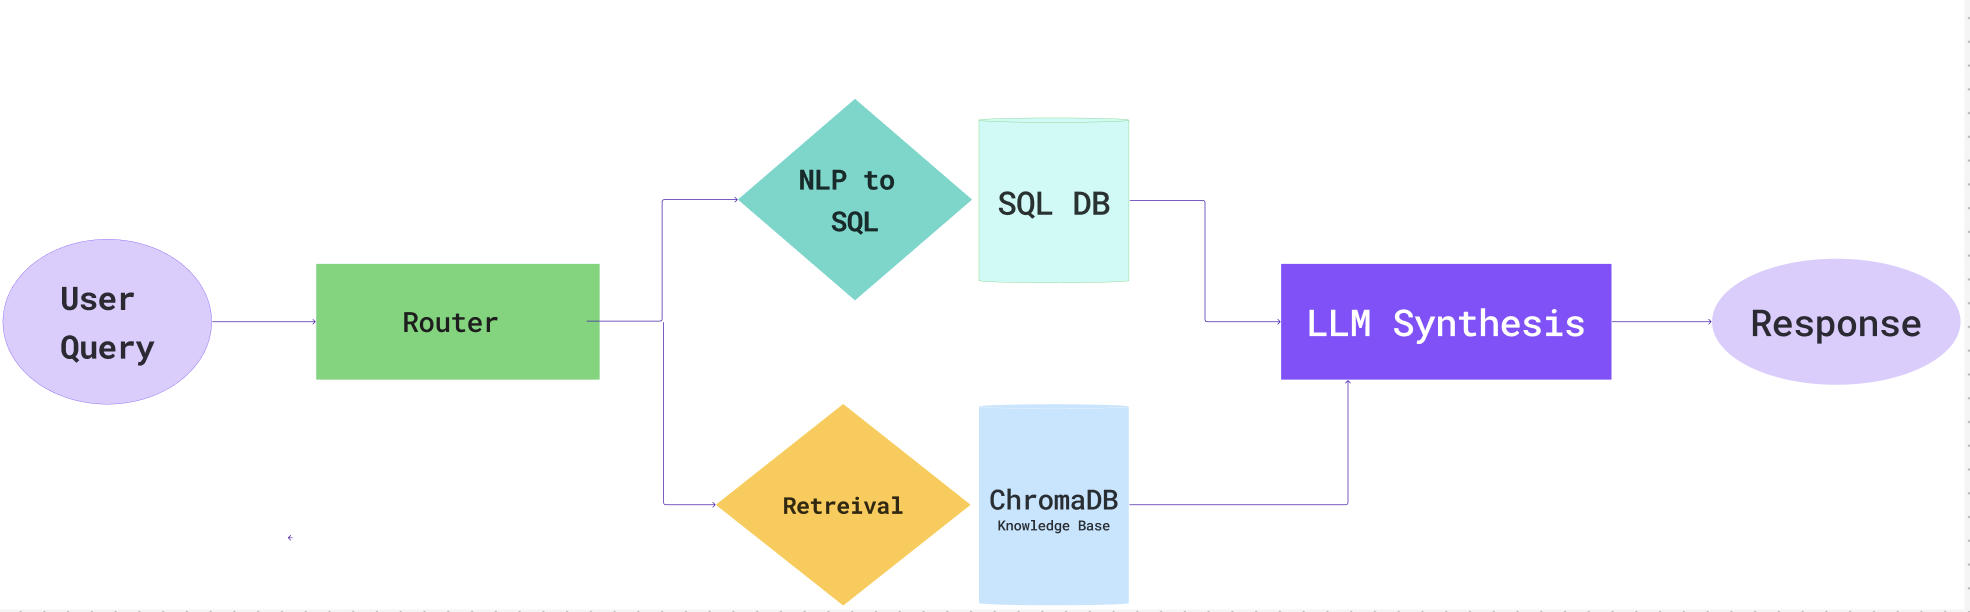

In [1]:
!pip install --quiet -U llama-index OpenAI llama-index-core nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 9.3 MB/s eta 0:00:00


In [5]:
!pip install langchain langchain_openai datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33


### Set OPENAI_API_KEY


In [3]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [20]:
import os
import json
from sqlalchemy import create_engine
from llama_index.core.query_engine import NLSQLTableQueryEngine
import pandas as pd
from llama_index.core import SQLDatabase
from llama_index.core import Document
from llama_index.core.schema import MetadataMode
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import NumberedListOutputParser
import os

In [7]:

df = pd.read_csv("/content/Copy of OpenSecrets.org _ FTX_Alameda Research Contributions - Direct Contributions & JFC Distributions.csv")
df['date'] = pd.to_datetime(df['date'])
df['amount'] = df['amount'].str.replace('$', '').str.replace(',', '').astype(float)

#Extract year
df['year'] = df['date'].dt.year
df.head()

,cycle,State/Federal,contribid,contrib,City,State,Zip,Fecoccemp,orgname,ultorg,...,amount,recipid,recipient,party,recipcode,type,fectransid,pg,cmteid,year
0,2022,State,1920715992,"KAUFMAN, WILLIE",NEW YORK,NY,10005,NaN,Alameda Research,NaN,...,400.0,55587498,"DICKSON, RUBY",D,DO,15,NaN,NaN,NaN,2022
1,2022,Federal,f1000218669,"BANKMAN, ALAN JOE",STANFORD,CA,94305,STANFORD AND FTX US,FTX.US,NaN,...,1000.0,N00051422,"Bond, Michelle",R,RL,15E,4082520221566200368,P,C00816561,2022
2,2020,Federal,j1001936195,"WETJEN, MARK",WASHINGTON,DC,20017,MIAMI INTERNATIONAL HOLDINGS,Miami International Holdings,NaN,...,5600.0,N00000699,"Menendez, Robert",D,DI,15E,T217948909,NaN,C00264564,2020
3,2020,Federal,j1001936195,"WETJEN, MARK",WASHINGTON,DC,20017,MIAMI INTERNATIONAL HOLDINGS,Miami International Holdings,NaN,...,4000.0,N00000699,"Menendez, Robert",D,DI,15E,T200003382,NaN,C00264564,2020
4,2022,Federal,j1001936195,"WETJEN, MARK",WASHINGTON,DC,20017,FTX,FTX.US,NaN,...,2900.0,N00004118,"Stabenow, Debbie",D,DI,15J,4042820221473189023,P,C00344473,2022


## Preprocess dataframe

In [38]:
def preprocess_dataframe(df):
    df = pd.read_csv("/content/Copy of OpenSecrets.org _ FTX_Alameda Research Contributions - Direct Contributions & JFC Distributions.csv")
    df['date'] = pd.to_datetime(df['date'])
    df['amount'] = df['amount'].str.replace('$', '').str.replace(',', '').astype(float)

    #Extract year
    df['year'] = df['date'].dt.year
    return df
df = pd.read_csv("/content/Copy of OpenSecrets.org _ FTX_Alameda Research Contributions - Direct Contributions & JFC Distributions.csv")
preprocessed_df = preprocess_dataframe(df)

##Create Database

In [39]:
def create_database(df, table_name, db_name):
    db_path = "sqlite:///"+db_name
    # Create engine
    engine = create_engine(db_path)
    table_name = table_name
    df.to_sql(name=table_name,con=engine,index=False)

    #wrap llama_index database layer
    sql_database = SQLDatabase(engine, sample_rows_in_table_info=4)
    sql_database
    return engine, sql_database

table_name, db_name = 'open_secrets', 'sample_db'
db_engine, sql_database = create_database(preprocessed_df, table_name, db_name)

## Get Table Metadata

In [40]:
def get_table_metadata(df):
    data_json = df.to_json(orient='records')
    data_json_list = json.loads(data_json)
    llama_docs = list()

    for data_json in data_json_list:
        for field in df.columns:
            data_json[field] = json.dumps(data_json[field])
        llama_doc = Document(
                      metadata = data_json,
                      text_format = "metadata:{metadata_str}\n---content:{content}" )
        llama_docs.append(llama_doc)
    return llama_docs

In [41]:
df_metadata = get_table_metadata(preprocessed_df)

## Use LLM to extract DB info

In [42]:
def get_table_info_using_LLM(df_metadata):
    prompt_schema = """
        Generate a database schema in JSON format based on the provided table metadata.

        Requirements:
        1. Create a valid JSON schema following this exact format:
        {{
               "open_secrets": {{
              "table_description": "A single sentence describing the table's purpose",
              "columns": {{
              "column_name": "description"
          }}
        }}
        }}

        2. Follow these rules:
        - Table description should be one clear, concise sentence
        - Each column description should be brief but informative
        - Use consistent language for similar types of columns
        - Preserve the exact column names as given

        Input Metadata:
        {doc}

        Return only the JSON schema, no additional text.
        """

    prompt_template = ChatPromptTemplate.from_template(prompt_schema)
    llm = ChatOpenAI(model='gpt-4o-mini')

    chain = prompt_template | llm | JsonOutputParser()

    table_info = chain.invoke({"doc": df_metadata})
    return table_info


In [43]:
table_info = get_table_info_using_LLM(df_metadata)

In [44]:
table_info

{'open_secrets': {'table_description': 'This table stores campaign contributions made to federal and state political entities.',
  'columns': {'cycle': 'The election cycle year.',
   'State/Federal': 'Indicates whether the contribution is for a state or federal election.',
   'contribid': 'Unique identifier for the contributor.',
   'contrib': 'Name of the contributor.',
   'City': 'City of the contributor.',
   'State': 'State of the contributor.',
   'Zip': 'Zip code of the contributor.',
   'Fecoccemp': 'Name of the employer or organization associated with the contribution.',
   'orgname': 'Name of the organization making the contribution.',
   'ultorg': 'Ultimate organization name (if applicable).',
   'date': 'Timestamp of the contribution.',
   'amount': 'Monetary amount of the contribution.',
   'recipid': 'Unique identifier for the recipient of the contribution.',
   'recipient': 'Name of the candidate or committee receiving the contribution.',
   'party': 'Political party affi

## Function to Convert NLP query to SQL

In [45]:
def Nlp_to_SQL_query(sql_database, table_name, table_info, nlp_query):
    sql_query_engine = NLSQLTableQueryEngine(sql_database=sql_database, tables=[table_name], table_context_dict=table_info )
    response = sql_query_engine.query(nlp_query)
    sql_query = response.metadata['sql_query']
    query_output = response.response
    return sql_query,query_output

In [69]:
sql_query,query_output = Nlp_to_SQL_query(sql_database, 'open_secrets', table_info, 'Find organizations with highest total contributions through different contributors')

In [70]:
sql_query

'SELECT orgname, SUM(amount) AS total_contributions\nFROM open_secrets\nGROUP BY orgname\nORDER BY total_contributions DESC'

In [ ]:
df

In [25]:
from llama_index.core.query_engine import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(sql_database=sql_database, tables=["open_secrets"], table_context_dict=table_info )

In [71]:
response = sql_query_engine.query("Find organizations with highest total contributions through different contributors")

In [72]:
print(response.metadata['sql_query'])

SELECT orgname, SUM(amount) AS total_contributions
FROM open_secrets
GROUP BY orgname
ORDER BY total_contributions DESC;


In [73]:
response.response

'The organizations with the highest total contributions through different contributors are West Realm Shires Services, Sullivan & Cromwell, Miax Exchange Group, Miami International Holdings, Ftxs, FTX.US, FTX Digital Markets, Alameda Research (Bahamas) Ltd, and Alameda Research.'

In [ ]:
print(response.metadata['sql_query'])

SELECT recipient, SUM(amount) as total_amount FROM open_secrets GROUP BY recipient ORDER BY total_amount DESC LIMIT 5;


## Main Function - NLP text to sql query generator


In [74]:
def run(df, db_name, table_name, sample_nlp_queries):

  #Preprocess dataframe
  preprocessed_df = preprocess_dataframe(df)

  #create database and llama_index db layer
  db_engine, sql_database = create_database(df, table_name, db_name)

  #extract metadata of table
  df_metadata = get_table_metadata(preprocessed_df)

  #Using Gpt-4 to extract table summary and col info
  table_info = get_table_info_using_LLM(df_metadata)

  Nlp_to_sql_query = list()
  for nlp_query in sample_nlp_queries:
      #Get NLP to SQL query
      sql_query,query_output = Nlp_to_SQL_query(sql_database, 'open_secrets', table_info, nlp_query)
      Nlp_to_sql_query.append((nlp_query,sql_query))

  return Nlp_to_sql_query



In [75]:
sample_nlp_queries = ['Find total contributions by each contributor.', 'List all contributions made in the year 2022.',
'Find the top 5 recipients who received the highest total contributions.', 'Count the number of contributions made by contributors from the state of California (CA).',
'Find the average contribution amount.', 'Tell me the maximum donation done by SBF.', 'What is the trend of contributions over different election cycles by party?', "Who are the top 10 contributors by total contribution amount?",
"Show contribution patterns by occupation/employer", "Show distribution of contribution types", "Find organizations with highest total contributions through different contributors"]

# Main function inputs :
df = pd.read_csv("/content/Copy of OpenSecrets.org _ FTX_Alameda Research Contributions - Direct Contributions & JFC Distributions.csv")
db_name ='sample_db'
table_name = 'open_secrets'

# Main Function : returns tuple with first element as NLP query and second element as SQL query.
Nlp_to_sql_query_list = run(df, db_name, table_name, sample_nlp_queries)


In [79]:
Nlp_to_sql_query_list

[('Find total contributions by each contributor.',
  'SELECT contrib, SUM(amount) AS total_contributions\nFROM open_secrets\nGROUP BY contrib\nORDER BY total_contributions DESC;'),
 ('List all contributions made in the year 2022.',
  'SELECT contribid, contrib, date, amount\nFROM open_secrets\nWHERE cycle = 2022\nORDER BY amount DESC;'),
 ('Find the top 5 recipients who received the highest total contributions.',
  'SELECT recipient, SUM(amount) AS total_contributions\nFROM open_secrets\nGROUP BY recipient\nORDER BY total_contributions DESC\nLIMIT 5;'),
 ('Count the number of contributions made by contributors from the state of California (CA).',
  "SELECT COUNT(*) \nFROM open_secrets\nWHERE State = 'CA';"),
 ('Find the average contribution amount.',
  'SELECT AVG(amount) AS avg_contribution_amount FROM open_secrets'),
 ('Tell me the maximum donation done by SBF.',
  "SELECT MAX(amount) \nFROM open_secrets \nWHERE orgname = 'SBF';"),
 ('What is the trend of contributions over different

In [76]:
sample_test_queries = pd.DataFrame(Nlp_to_sql_query_list, columns = ['NLP_query', 'SQL_query'])

In [78]:
sample_test_queries

,NLP_query,SQL_query
0,Find total contributions by each contributor.,"SELECT contrib, SUM(amount) AS total_contribut..."
1,List all contributions made in the year 2022.,"SELECT contribid, contrib, date, amount\nFROM ..."
2,Find the top 5 recipients who received the hig...,"SELECT recipient, SUM(amount) AS total_contrib..."
3,Count the number of contributions made by cont...,SELECT COUNT(*) \nFROM open_secrets\nWHERE Sta...
4,Find the average contribution amount.,SELECT AVG(amount) AS avg_contribution_amount ...
5,Tell me the maximum donation done by SBF.,SELECT MAX(amount) \nFROM open_secrets \nWHERE...
6,What is the trend of contributions over differ...,"SELECT cycle, party, SUM(amount) AS total_cont..."
7,Who are the top 10 contributors by total contr...,"SELECT contrib, SUM(amount) AS total_contribut..."
8,Show contribution patterns by occupation/employer,"SELECT orgname, ultorg, SUM(amount) AS total_c..."
9,Show distribution of contribution types,"SELECT type, COUNT(*) as num_contributions\nFR..."


In [77]:
sample_test_queries.to_csv('sample_test_queries_output.csv')

In [130]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata

sql_tool = QueryEngineTool(
    query_engine=sql_query_engine,
    metadata=ToolMetadata(
        name="DB_query_tool",
        description="""
        {Table_info}

        The tool converts natural language questions into SQL queries. And later executes sql query on database to fetch output.
        Input should be a clear question about campaign contributions.
        """
    )
)

## Part 2: building knowledge base around Airbnb listings data

In [82]:
from datasets import load_dataset
import pandas as pd

data = load_dataset("MongoDB/airbnb_embeddings", split="train", streaming=True)
data = data.take(500)
data_df = pd.DataFrame(data)
data_df['address'].head()
data_df = data_df.drop(columns=['text_embeddings'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

In [134]:
data_df.columns

Index(['_id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'maximum_nights', 'cancellation_policy',
       'last_scraped', 'calendar_last_scraped', 'first_review', 'last_review',
       'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'bathrooms',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'guests_included', 'images', 'host', 'address',
       'availability', 'review_scores', 'reviews', 'weekly_price',
       'monthly_price', 'image_embeddings'],
      dtype='object')

In [85]:
import json

data_json = data_df.to_json(orient='records')
data_json_list = json.loads(data_json)

import json
from llama_index.core import Document
from llama_index.core.schema import MetadataMode
from llama_index.core.node_parser import SentenceSplitter
from tqdm import tqdm

llama_docs = list()

for data_json in data_json_list:
    for field in ["amenities", "images", "host", "address", "availability", "review_scores", "reviews", "image_embeddings"]:
        data_json[field] = json.dumps(data_json[field])
    llama_doc = Document(text = data_json["description"],
                      metadata = data_json,
                      excluded_llm_metadata_keys = ["_id", "transit", "minimum_nights", "maximum_nights", "cancellation_policy", "last_scraped", "calendar_last_scraped", "first_review", "last_review", "security_deposit", "cleaning_fee", "guests_included", "host", "availability", "reviews", "image_embeddings"],
                      excluded_embed_metadata_keys = ["_id", "transit", "minimum_nights", "maximum_nights", "cancellation_policy", "last_scraped", "calendar_last_scraped", "first_review", "last_review", "security_deposit", "cleaning_fee", "guests_included", "host", "availability", "reviews", "image_embeddings"],
                      metadata_format = "{key} => {value}",
                      text_format = "metadata:{metadata_str}\n---content:{content}" )
    llama_docs.append(llama_doc)


In [89]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI

sentence_splitter = SentenceSplitter(chunk_size =5000, chunk_overlap =200)
embed_model = OpenAIEmbedding(model='text-embedding-3-small', dimensions = 256, batch = 20)
Settings.embed_model = embed_model
sentence_nodes = sentence_splitter.get_nodes_from_documents(llama_docs)

for node in sentence_nodes:
    node_embed = embed_model.get_text_embedding(node.get_content(metadata_mode=MetadataMode.EMBED))
    node.embedding = node_embed

KeyboardInterrupt: 

In [94]:
!pip install --quiet chromadb llama-index-vector-stores-chroma

In [95]:
from llama_index.core import StorageContext, VectorStoreIndex
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

chroma_client = chromadb.PersistentClient(path="./chroma_db")
chroma_collection = chroma_client.get_or_create_collection(name='airbnb')

# Create ChromaVectorStore
vector_store = ChromaVectorStore(client =chroma_client, chroma_collection=chroma_collection)

In [96]:
from llama_index.core import StorageContext, VectorStoreIndex

# Create a storage context
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Create the index with the storage context
index = VectorStoreIndex(sentence_nodes, storage_context=storage_context)

# Optionally, persist the index
index.storage_context.persist()

In [121]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata

index_retreiver = index.as_query_engine(top_similarity_k=5)

index_tool = QueryEngineTool(query_engine = index_retreiver, metadata= ToolMetadata(
        name="airbnb_knowledge_base",
        description=(
            "Provides information about Airbnb listings and reviews. "
            "Use a detailed plain text question as input to the tool."
        ),
    ),)

In [112]:
from typing import Dict, List, Any, Optional
from llama_index.core.tools import BaseTool
from llama_index.core.llms import ChatMessage
from llama_index.core.llms.llm import ToolSelection, LLM
from llama_index.core.workflow import (
    Workflow,
    Event,
    StartEvent,
    StopEvent,
    step,
)
from llama_index.core.base.response.schema import Response
from llama_index.core.tools import FunctionTool
from llama_index.core.workflow import Context


class InputEvent(Event):
    """Input event."""

class GatherToolsEvent(Event):
    """Gather Tools Event"""

    tool_calls: Any

class ToolCallEvent(Event):
    """Tool Call event"""

    tool_call: ToolSelection

class ToolCallEventResult(Event):
    """Tool call event result."""

    msg: ChatMessage
class RouterOutputAgentWorkflow(Workflow):
    """Custom router output agent workflow."""

    def __init__(self,
        tools: List[BaseTool],
        timeout: Optional[float] = 10.0,
        disable_validation: bool = False,
        verbose: bool = False,
        llm: Optional[LLM] = None,
        chat_history: Optional[List[ChatMessage]] = None,
    ):
        """Constructor."""

        super().__init__(timeout=timeout, disable_validation=disable_validation, verbose=verbose)

        self.tools: List[BaseTool] = tools
        self.tools_dict: Optional[Dict[str, BaseTool]] = {tool.metadata.name: tool for tool in self.tools}
        self.llm: LLM = llm or OpenAI(temperature=0, model="gpt-3.5-turbo")
        self.chat_history: List[ChatMessage] = chat_history or []


    def reset(self) -> None:
        """Resets Chat History"""

        self.chat_history = []

    @step()
    async def prepare_chat(self, ev: StartEvent) -> InputEvent:
        message = ev.get("message")
        if message is None:
            raise ValueError("'message' field is required.")

        # add msg to chat history
        chat_history = self.chat_history
        chat_history.append(ChatMessage(role="user", content=message))
        return InputEvent()

    @step()
    async def chat(self, ev: InputEvent) -> GatherToolsEvent | StopEvent:
        """Appends msg to chat history, then gets tool calls."""

        # Put msg into LLM with tools included
        chat_res = await self.llm.achat_with_tools(
            self.tools,
            chat_history=self.chat_history,
            verbose=self._verbose,
            allow_parallel_tool_calls=True
        )
        tool_calls = self.llm.get_tool_calls_from_response(chat_res, error_on_no_tool_call=False)

        ai_message = chat_res.message
        self.chat_history.append(ai_message)
        if self._verbose:
            print(f"Chat message: {ai_message.content}")

        # no tool calls, return chat message.
        if not tool_calls:
            return StopEvent(result=ai_message.content)

        return GatherToolsEvent(tool_calls=tool_calls)

    @step(pass_context=True)
    async def dispatch_calls(self, ctx: Context, ev: GatherToolsEvent) -> ToolCallEvent:
        """Dispatches calls."""

        tool_calls = ev.tool_calls
        await ctx.set("num_tool_calls", len(tool_calls))

        # trigger tool call events
        for tool_call in tool_calls:
            ctx.send_event(ToolCallEvent(tool_call=tool_call))

        return None

    @step()
    async def call_tool(self, ev: ToolCallEvent) -> ToolCallEventResult:
        """Calls tool."""

        tool_call = ev.tool_call

        # get tool ID and function call
        id_ = tool_call.tool_id

        if self._verbose:
            print(f"Calling function {tool_call.tool_name} with msg {tool_call.tool_kwargs}")

        # call function and put result into a chat message
        tool = self.tools_dict[tool_call.tool_name]
        output = await tool.acall(**tool_call.tool_kwargs)
        msg = ChatMessage(
            name=tool_call.tool_name,
            content=str(output),
            role="tool",
            additional_kwargs={
                "tool_call_id": id_,
                "name": tool_call.tool_name
            }
        )

        return ToolCallEventResult(msg=msg)

    @step(pass_context=True)
    async def gather(self, ctx: Context, ev: ToolCallEventResult) -> StopEvent | None:
        """Gathers tool calls."""
        # wait for all tool call events to finish.
        tool_events = ctx.collect_events(ev, [ToolCallEventResult] * await ctx.get("num_tool_calls"))
        if not tool_events:
            return None

        for tool_event in tool_events:
            # append tool call chat messages to history
            self.chat_history.append(tool_event.msg)

        # # after all tool calls finish, pass input event back, restart agent loop
        return InputEvent()

In [131]:
wf = RouterOutputAgentWorkflow(tools=[sql_tool, index_tool], verbose=True, timeout=180)

In [136]:
result = await wf.run(message="Which properties offer the best value for monthly stays, comparing monthly_price to regular price and including cleaning fees?")

Running step prepare_chat
Step prepare_chat produced event InputEvent
Running step chat
Chat message: None
Step chat produced event GatherToolsEvent
Running step dispatch_calls
Step dispatch_calls produced no event
Running step call_tool
Calling function airbnb_knowledge_base with msg {'input': 'Which properties offer the best value for monthly stays, comparing monthly_price to regular price and including cleaning fees?'}
Step call_tool produced event ToolCallEventResult
Running step gather
Step gather produced event InputEvent
Running step chat
Chat message: The context information does not provide sufficient details about monthly prices or cleaning fees for the properties. Therefore, it's not possible to determine which property offers the best value for monthly stays. If you have specific criteria or preferences, please let me know so I can assist you further.
Step chat produced event StopEvent
